In [2]:
using Pkg

Pkg.activate(mktempdir())

Pkg.add([
    "Random",
    "Statistics",
    "LinearAlgebra",
    "Plots"
])

Pkg.update()

  Activating new project at `C:\Users\79021\AppData\Local\Temp\jl_JDfwII`
  Installing known registries into `C:\Users\79021\.julia`
       Added `General` registry to C:\Users\79021\.julia\registries
    Updating registry at `C:\Users\79021\.julia\registries\General.toml`
   Resolving package versions...
   Installed Libmount_jll ───────────────── v2.41.2+0
   Installed libdecor_jll ───────────────── v0.2.2+0
   Installed LERC_jll ───────────────────── v4.0.1+0
   Installed x265_jll ───────────────────── v4.1.0+0
   Installed GR_jll ─────────────────────── v0.73.19+1
   Installed Preferences ────────────────── v1.5.0
   Installed LoggingExtras ──────────────── v1.2.0
   Installed Opus_jll ───────────────────── v1.5.2+0
   Installed libfdk_aac_jll ─────────────── v2.0.4+0
   Installed JpegTurbo_jll ──────────────── v3.1.3+0
   Installed Xorg_xkbcomp_jll ───────────── v1.4.7+0
   Installed RelocatableFolders ─────────── v1.0.1
   Installed ColorSchemes ───────────────── v3.31.0
   Insta

k-NN (k=1): MSE = 1.0493
k-NN (k=3): MSE = 0.7869
k-NN (k=5): MSE = 0.7552
k-NN (k=10): MSE = 0.7574
k-NN (k=20): MSE = 0.6516

Linear Regression: MSE = 0.016
Learned weights (first 5): Float32[1.016, 0.004, -0.01, -0.01, -0.007]

Test sample 1:
True y = 0.367
k-NN (k=5) = 0.035
Linear reg = 0.259


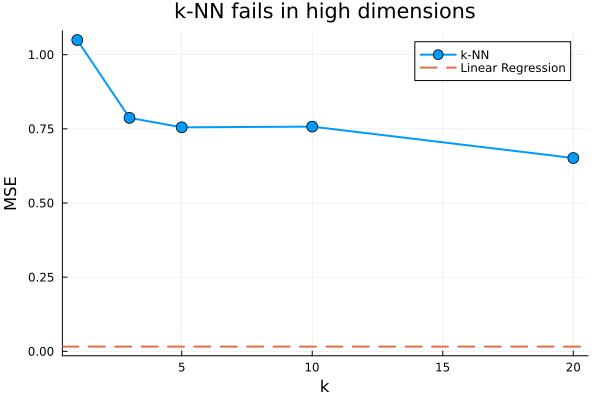

In [5]:
using Random, Statistics, LinearAlgebra, Plots

Random.seed!(42)

# Problem setup: 100 features but only x₁ is relevant
n_features = 100
n_train = 200
n_test = 50

# Generate isotropic Gaussian data: x ~ N(Θ, I₁₀₀)
X_train = randn(Float32, n_train, n_features)
X_test = randn(Float32, n_test, n_features)

# True function: y = x₁ + ϵ where ϵ ~ N(0, 0.1²)
# Only the first feature matters!
y_train = X_train[:,1] + 0.1f0 * randn(Float32, n_train)
y_test = X_test[:,1] + 0.1f0 * randn(Float32, n_test)

# k-NN prediction for single test point
# Computes L² distance: ||x_train[i] - x_test||₂²
function knn_predict(X_train, y_train, x_test, k)
    # Calculate Euclidean distance to all training points
    distances = [norm(X_train[i, :] - x_test) for i in 1:size(X_train, 1)]

    # Find indices o k nearest neighbours
    nearest_indices = partialsortperm(distances, 1:k)

    # Return average of their y values
    return mean(y_train[nearest_indices])
end

# Batch prediction wrapperr
function knn_predict_batch(X_train, y_train, X_test, k)
    return [knn_predict(X_train, y_train, X_test[i, :], k) for i in 1:size(X_test, 1)]
end

# Test differenc k values
k_values = [1, 3, 5, 10, 20]
knn_errors = Float32[]

for k in k_values
    y_pred = knn_predict_batch(X_train, y_train, X_test, k)
    mse = mean((y_pred .- y_test).^2)
    push!(knn_errors, mse)
    println("k-NN (k=$k): MSE = $(round(mse, digits=4))")
end

# Linear regression: can learn feature importance via weights
# Add bias term (intercept)
X_train_bias = hcat(ones(Float32, n_train), X_train)
X_test_bias = hcat(ones(Float32, n_test), X_test)

# Closed-form solution: w = (X'X)⁻¹X'y
w = (X_train_bias' * X_train_bias) \ (X_train_bias' * y_train)

y_pred_lr = X_test_bias * w
lr_mse = mean((y_pred_lr .- y_test).^2)
println("\nLinear Regression: MSE = $(round(lr_mse, digits=4))")
# w[2] should be ≈1, w[3:end] should be ≈0
println("Learned weights (first 5): ", round.(w[2:6], digits=3))

# Compare predictions for a single test point
sample_idx = 1
println("\nTest sample $sample_idx:")
println("True y = $(round(y_test[sample_idx], digits=3))")
println("k-NN (k=5) = $(round(knn_predict(X_train, y_train, X_test[sample_idx, :], 5), digits=3))")
println("Linear reg = $(round(y_pred_lr[sample_idx], digits=3))")

# Visualisation: k-NN fails regardless of k choice
# Distance dominated by 99 irrelevant features
plot(k_values, knn_errors, label="k-NN", marker=:circle,
    xlabel="k", ylabel="MSE", title="k-NN fails in high dimensions",
    linewidth=2, markersize=6, legend=:topright)
hline!([lr_mse], label="Linear Regression", linestyle=:dash, linewidth=2)
